In [3]:

import json
import gzip
from io import BytesIO
import boto3
import random
import pandas as pd
from tqdm import tqdm
import numpy as np
import altair as alt
import ast
from sklearn.metrics import pairwise_distances
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import hdbscan

In [4]:
page_texts = pd.read_parquet("../Data/ppa_corpus_2025-02-03_1308/keywords_and_top_1000_edited.parquet")
page_texts = page_texts[~page_texts['page_text'].isna()]

In [5]:
metadata = pd.read_csv("../Data/ppa_corpus_2025-02-03_1308/ppa_metadata.csv")

In [6]:
focus_forms = ['Lyric', 'Ballad', 'Sonnet', 'Free Verse', 'Song']
file_path = "../Output Data/selected_forms.jsonl"
with open(file_path, 'r') as f:
    first_line = f.readline().strip()
    print(first_line)

selected_forms = []
with open(file_path, 'r') as f:
    for line in f:
        data = json.loads(line)
        if data['poetic_form'] in focus_forms:
            selected_forms.append(data)
selected_forms_df = pd.DataFrame(selected_forms)


{"page_id": "A01224.11", "work_id": "A01224", "poetic_form": "Song", "spelling": "song", "char_start": 17, "char_end": 22, "context": "\nTorquat. Tass. 2 Song of Olindo and Sophronia.\nMa il sospettoso t\u00e8stimo periglio\nTanta virt\u00f9 congiunta hauer vicina,\nOnde", "embedding": [35.35183334350586, -28.09755516052246, -25.063199996948242, 0.07509160041809082, 1.8704451322555542, 2.889286518096924, -24.023181915283203, -48.77571105957031, -0.45325636863708496, 10.62868881225586, -8.241374015808105, -7.505980014801025, 23.847854614257812, 20.04280662536621, 66.56129455566406, 6.530691146850586, 41.801490783691406, -1.2189273834228516, -7.0289154052734375, -7.528559684753418, 2.245206832885742, -23.390968322753906, 44.86824417114258, -45.0345458984375, -1.675862431526184, -20.06988525390625, 10.360995292663574, 12.307893753051758, 6.483567237854004, -14.792271614074707, -25.356788635253906, -111.15299987792969, -18.543981552124023, -35.52568054199219, 1.7164387702941895, 11.9988088

In [7]:
selected_forms_df['poetic_form'].unique()

array(['Song', 'Sonnet', 'Ballad', 'Lyric'], dtype=object)

In [8]:
metadata = metadata[['work_id', 'author', 'pub_year']]
page_texts = pd.read_parquet("../Data/ppa_corpus_2025-02-03_1308/keywords_and_top_1000_edited.parquet")


In [9]:
page_texts = page_texts[~page_texts['page_text'].isna()]
page_texts = page_texts[['page_id', 'page_text']]
page_texts = page_texts.drop_duplicates(subset=['page_id'])
df_embeddings = selected_forms_df.merge(page_texts, on='page_id', how='left')
df_embeddings = df_embeddings.merge(metadata, how = 'left', on = 'work_id')

In [10]:
# df_embeddings = pd.read_csv(
#     "../Output Data/embeddings.csv",
#     converters={"embedding": json.loads}  # slightly faster than ast.literal_eval
# )

In [11]:
#Trying to identify paratext uses of the forms

paratext_uses = df_embeddings.groupby(['work_id', 'poetic_form', 'char_start', 'char_end']).size().reset_index(name='counts').sort_values(by = 'counts', ascending=False)

#filter paratext_uses to only those with counts > 1
paratext_uses = paratext_uses[paratext_uses['counts'] > 5]
df_filtered = df_embeddings.merge(paratext_uses[['work_id', 'poetic_form', 'char_start', 'char_end']], on=['work_id', 'poetic_form', 'char_start', 'char_end'], how='left', indicator=True)
df_filtered = df_filtered[df_filtered['_merge'] == 'left_only'].drop(columns=['_merge'])

In [12]:
paratext_uses


,work_id,poetic_form,char_start,char_end,counts
138101,uc2.ark:/13960/t9765d284,Ballad,7,14,271
60013,mdp.39015032130596,Lyric,18,24,151
52404,mdp.39015030120938,Lyric,3,9,142
90578,nyp.33433067299424,Lyric,0,5,137
14557,coo1.ark:/13960/t20c5h895,Lyric,3,9,133
...,...,...,...,...,...
4252,CW0110636874,Sonnet,0,6,6
5577,CW0112055939,Song,8,15,6
60009,mdp.39015032130596,Lyric,14,20,6
90368,nyp.33433067299101,Song,0,4,6


In [13]:
len(df_filtered) / len(df_embeddings)

0.9443994569022729

In [14]:
#normalize df_filtered embeddings to unit length
embeddings = np.array(df_filtered['embedding'].tolist())
norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
normalized_embeddings = embeddings / norms
df_filtered['embedding'] = list(normalized_embeddings)

## Clustering

In [14]:


def cluster_usages_by_form(
    df,
    forms =None,
    vector_col="embedding",
    k_range=range(2, 11),
    n_init="auto",
    random_state=None,
):
    """
    Performs KMeans clustering within each distinct form in the dataframe.

    Returns
    -------
    clustered_df : pd.DataFrame
        Original dataframe with an added 'cluster' column.
    silhouette_df : pd.DataFrame
        One row per (form, k) with silhouette scores.
    """
    if forms is None:
        forms = df["poetic_form"].unique()
    clustered_results = []
    silhouette_records = []

    for form, df_form in df.groupby("poetic_form"):
        if form not in forms:
            continue

        print(f"\n=== Clustering form: {form} ===")

        Uw_std = np.vstack(df_form[vector_col].values)
        # Uw_std = StandardScaler().fit_transform(Uw)
        best_silhouette = -1
        best_labels = None
        best_k = None

        for k in k_range:
            if len(df_form) <= k:
                continue

            model = KMeans(
                n_clusters=k,
                n_init=n_init,
                random_state=random_state,
            )
            model.fit(Uw_std)

            labels = model.labels_
            if 1 < len(set(labels)) < len(Uw_std):
                sil = silhouette_score(Uw_std, labels)
            else:
                sil = -1

            silhouette_records.append({
                "form": form,
                "k": k,
                "silhouette": sil,
            })

            print(f"Form={form}, K={k}, silhouette={sil:.4f}")

            if sil > best_silhouette:
                best_silhouette = sil
                best_labels = labels
                best_k = k

        df_form_out = df_form.copy()
        df_form_out["cluster"] = best_labels if best_labels is not None else -1
        clustered_results.append(df_form_out)

        print(f"Best K for form '{form}': {best_k} (sil={best_silhouette:.4f})")

    clustered_df = pd.concat(clustered_results, ignore_index=True)
    silhouette_df = pd.DataFrame(silhouette_records)

    return clustered_df, silhouette_df



In [15]:
clustering_results = cluster_usages_by_form(df_filtered)


=== Clustering form: Ballad ===


Python(69179) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Form=Ballad, K=2, silhouette=0.1297
Form=Ballad, K=3, silhouette=0.1181
Form=Ballad, K=4, silhouette=0.1732
Form=Ballad, K=5, silhouette=0.1751
Form=Ballad, K=6, silhouette=0.1684
Form=Ballad, K=7, silhouette=0.1538
Form=Ballad, K=8, silhouette=0.1599
Form=Ballad, K=9, silhouette=0.1364
Form=Ballad, K=10, silhouette=0.1377
Best K for form 'Ballad': 5 (sil=0.1751)

=== Clustering form: Lyric ===
Form=Lyric, K=2, silhouette=0.1235
Form=Lyric, K=3, silhouette=0.1326
Form=Lyric, K=4, silhouette=0.1527
Form=Lyric, K=5, silhouette=0.1035
Form=Lyric, K=6, silhouette=0.1215
Form=Lyric, K=7, silhouette=0.1370
Form=Lyric, K=8, silhouette=0.0978
Form=Lyric, K=9, silhouette=0.1141
Form=Lyric, K=10, silhouette=0.1168
Best K for form 'Lyric': 4 (sil=0.1527)

=== Clustering form: Song ===
Form=Song, K=2, silhouette=0.1193
Form=Song, K=3, silhouette=0.1141
Form=Song, K=4, silhouette=0.1981
Form=Song, K=5, silhouette=0.1790
Form=Song, K=6, silhouette=0.1999
Form=Song, K=7, silhouette=0.1992
Form=Song, 

In [16]:
table = clustering_results[1]
table[table['form'] == 'Song']['silhouette'].to_clipboard()

Python(69500) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [21]:
# df_with_clusters = clustering_results[0]
# df_with_clusters.to_csv("../Output Data/filtered_usages_with_clusters_norm.csv", index=False)
df_with_clusters = pd.read_csv(
    "../Output Data/filtered_usages_with_clusters_norm.csv",
    converters={
        "embedding": lambda x: np.fromstring(x.strip("[]"), sep=" ")
    }
)

In [ ]:
df_with_clusters[df_with_clusters['poetic_form'] == 'Lyric']

Index(['page_id', 'work_id', 'poetic_form', 'spelling', 'char_start',
       'char_end', 'context', 'embedding', 'page_text', 'author', 'pub_year',
       'cluster'],
      dtype='object')

In [39]:
df_with_clusters[(df_with_clusters['poetic_form'] == 'Lyric') & df_with_clusters['context'].str.contains("There never was\na time\nwhen little poems were more abundant, or more care-\nfully finished, but a lyric", case=False)]

,page_id,work_id,poetic_form,spelling,char_start,char_end,context,embedding,page_text,author,pub_year,cluster
47664,uc1.b3337717.00000133,uc1.b3337717,Lyric,lyric,283,289,gn. There never was\na time\nwhen little poems...,"[0.0104395097, -0.0425541024, -0.00317700733, ...","SPECIAL QUALITY OF THE SONG.\n101\nthe ear,\n-...","Stedman, Edmund Clarence, 1833-1908",1875.0,1


In [ ]:
top_words = pd.read_csv("../Output Data/other_forms_avg.csv")

In [19]:


from sklearn.metrics.pairwise import cosine_similarity
similarity_records = []
for form, df_form in df_with_clusters.groupby("poetic_form"):
    cluster_centers = df_form.groupby("cluster")['embedding'].apply(lambda x: np.mean(np.vstack(x), axis=0)).to_dict()
    clusters = list(cluster_centers.keys())
    embeddings = np.vstack(list(cluster_centers.values()))
    cosine_sim_matrix = cosine_similarity(embeddings)
    
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            similarity_records.append({
                "form": form,
                "cluster_1": clusters[i],
                "cluster_2": clusters[j],
                "cosine_similarity": cosine_sim_matrix[i, j],
            })

print(similarity_records)


[{'form': 'Ballad', 'cluster_1': 0, 'cluster_2': 1, 'cosine_similarity': np.float64(0.9288748610212966)}, {'form': 'Ballad', 'cluster_1': 0, 'cluster_2': 2, 'cosine_similarity': np.float64(0.9140841999433921)}, {'form': 'Ballad', 'cluster_1': 0, 'cluster_2': 3, 'cosine_similarity': np.float64(0.93594244048148)}, {'form': 'Ballad', 'cluster_1': 0, 'cluster_2': 4, 'cosine_similarity': np.float64(0.7688572056585399)}, {'form': 'Ballad', 'cluster_1': 1, 'cluster_2': 2, 'cosine_similarity': np.float64(0.960737096494656)}, {'form': 'Ballad', 'cluster_1': 1, 'cluster_2': 3, 'cosine_similarity': np.float64(0.9755565745755159)}, {'form': 'Ballad', 'cluster_1': 1, 'cluster_2': 4, 'cosine_similarity': np.float64(0.7810963316620514)}, {'form': 'Ballad', 'cluster_1': 2, 'cluster_2': 3, 'cosine_similarity': np.float64(0.9648346325438283)}, {'form': 'Ballad', 'cluster_1': 2, 'cluster_2': 4, 'cosine_similarity': np.float64(0.815716341845467)}, {'form': 'Ballad', 'cluster_1': 3, 'cluster_2': 4, 'cosine

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

def get_top_words_for_clusters(df, top_words, vector_col="embedding", top_n=15):
    cluster_top_words = {}

    word_embeddings = np.vstack(
        top_words["embedding"].apply(ast.literal_eval).values
    )

    for (form, cluster), df_group in df.groupby(["poetic_form", "cluster"]):

        avg_embedding = np.mean(
            np.vstack(df_group[vector_col].values),
            axis=0
        ).reshape(1, -1)

        similarities = cosine_similarity(
            avg_embedding,
            word_embeddings
        ).flatten()

        top_indices = np.argsort(similarities)[::-1][:top_n]

        top_words_with_similarities = [
            (
                top_words.iloc[i]["poetic_form"],
                float(similarities[i])
            )
            for i in top_indices
        ]

        cluster_top_words[(form, cluster)] = top_words_with_similarities

    return cluster_top_words
cluster_top_words = get_top_words_for_clusters(df_with_clusters, top_words)
cluster_top_words

{('Ballad', np.int32(0)): [('historical', 0.8883537808608183),
  ('critical', 0.8872182026285436),
  ('ing', 0.8856483914625395),
  ('dramatic', 0.8854126392360389),
  ('practical', 0.8853472877092716),
  ('par', 0.8829557379394897),
  ('british', 0.8822844184520929),
  ('double', 0.881955433133142),
  ('sub', 0.8805314749596153),
  ('robert', 0.880216099493896),
  ('royal', 0.8799389730422201),
  ('gentle', 0.879267192999639),
  ('eng', 0.8791057456011389),
  ('famous', 0.8781023605188583),
  ('literary', 0.8779279140624903)],
 ('Ballad', np.int32(1)): [('double', 0.9111019551559961),
  ('gentle', 0.9099992855722028),
  ('dramatic', 0.909881764993684),
  ('famous', 0.9096332247915256),
  ('strange', 0.9086661204487463),
  ('royal', 0.9061680972268673),
  ('soft', 0.9056662858168826),
  ('grand', 0.9047168194433659),
  ('ing', 0.9039413139263477),
  ('draw', 0.9038728741924151),
  ('golden', 0.9036048265065206),
  ('direct', 0.9032043739569027),
  ('little', 0.9030532842374019),
  ('po

In [22]:
df_filtered['poetic_form'].value_counts()

poetic_form
Song      87751
Ballad    25920
Lyric     24526
Sonnet    16914
Name: count, dtype: int64

In [16]:
import hdbscan

def hdbscan_cluster_by_form(
    df,
    forms=None,
    vector_col="embedding",
    min_cluster_size=1000,
    min_samples=250,
):
    """
    Performs HDBSCAN clustering within each distinct form in the dataframe.

    Returns
    -------
    clustered_df : pd.DataFrame
        Original dataframe with added 'hdbscan_cluster' and 'hdbscan_prob' columns.
    stats_df : pd.DataFrame
        One row per form with clustering statistics.
    """
    if forms is None:
        forms = df["poetic_form"].unique()
    
    clustered_results = []
    stats_records = []

    for form, df_form in df.groupby("poetic_form"):
        if form not in forms:
            continue

        print(f"\n=== Clustering form: {form} ===")

        Uw = np.vstack(df_form[vector_col].values)
        
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            metric='euclidean'
        )
        cluster_labels = clusterer.fit_predict(Uw)
        
        # Calculate statistics
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        n_noise = np.sum(cluster_labels == -1)
        
        # Calculate silhouette score if we have valid clusters
        if n_clusters > 1 and n_noise < len(cluster_labels):
            # Only compute silhouette on non-noise points
            non_noise_mask = cluster_labels != -1
            if np.sum(non_noise_mask) > n_clusters:
                sil = silhouette_score(
                    Uw[non_noise_mask], 
                    cluster_labels[non_noise_mask]
                )
            else:
                sil = -1
        else:
            sil = -1
        
        stats_records.append({
            "form": form,
            "n_clusters": n_clusters,
            "n_noise": n_noise,
            "silhouette": sil,
        })
        
        print(f"Form={form}, n_clusters={n_clusters}, n_noise={n_noise}, silhouette={sil:.4f}")
        
        df_form_out = df_form.copy()
        df_form_out["hdbscan_cluster"] = cluster_labels
        df_form_out["hdbscan_prob"] = clusterer.probabilities_
        clustered_results.append(df_form_out)

    clustered_df = pd.concat(clustered_results, ignore_index=True)
    stats_df = pd.DataFrame(stats_records)

    return clustered_df, stats_df

In [1]:
clustering_results_hdbscan = hdbscan_cluster_by_form(df_filtered, min_cluster_size=500, min_samples=100)

NameError: name 'hdbscan_cluster_by_form' is not defined

In [41]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import ast

def centroid_medoid(embeddings):
    centroid = embeddings.mean(axis=0, keepdims=True)
    sims = cosine_similarity(embeddings, centroid).flatten()
    return embeddings[np.argmax(sims)].reshape(1, -1)


def get_top_words_for_clusters_medoids(
    df,
    top_words,
    vector_col="embedding",
    top_n=15
):
    cluster_top_words = {}

    # prepare comparison embeddings once
    word_embeddings = np.vstack(
        top_words["embedding"].apply(ast.literal_eval).values
    )

    for (form, cluster), df_group in df.groupby(["poetic_form", "cluster"]):

        cluster_embeddings = np.vstack(df_group[vector_col].values)

        # 🔁 MEDOID instead of mean
        rep_embedding = centroid_medoid(cluster_embeddings)

        similarities = cosine_similarity(
            rep_embedding,
            word_embeddings
        ).flatten()

        top_indices = np.argsort(similarities)[::-1][:top_n]

        top_words_with_similarities = [
            (
                top_words.iloc[i]["poetic_form"],
                float(similarities[i])
            )
            for i in top_indices
        ]

        cluster_top_words[(form, cluster)] = top_words_with_similarities

    return cluster_top_words


In [20]:
cluster_top_words_medoids = get_top_words_for_clusters_medoids(df_with_clusters, top_words)
cluster_top_words_medoids

{('Ballad', np.int32(0)): [('elocution', 0.9987266198227767),
  ('anglo', 0.9986919506429552),
  ('london', 0.9984963428355775),
  ('grammar', 0.9983547228059503),
  ('poetry', 0.9977526305038433),
  ('syntax', 0.997560861393407),
  ('france', 0.9975491776891924),
  ('etc', 0.997543508857566),
  ('preface', 0.9975260929035654),
  ('literature', 0.9974349884475747),
  ('italy', 0.9973845270669963),
  ('rome', 0.997255140259845),
  ('rhetoric', 0.9971543441607614),
  ('england', 0.9971377088786852),
  ('tongue', 0.9970755316128437)],
 ('Ballad', np.int32(1)): [('dramatic', 0.913695091082866),
  ('poetic', 0.90650565023599),
  ('poetical', 0.8997754623320259),
  ('literary', 0.899244014962588),
  ('double', 0.8981805045900046),
  ('moral', 0.8949108414553856),
  ('popular', 0.8942908084978795),
  ('famous', 0.8932695230756135),
  ('gentle', 0.8928880613391418),
  ('plea', 0.8918970859218277),
  ('grand', 0.8916720476043519),
  ('tender', 0.8912274671585115),
  ('roman', 0.8908600597806622

In [42]:
# can i grab the five rows in each cluster with the embedding closest to the centroid and return in a dataframe

def get_representative_usages(df, vector_col="embedding", top_n=5):
    representative_records = []

    for (form, cluster), df_group in df.groupby(["poetic_form", "cluster"]):

        cluster_embeddings = np.vstack(df_group[vector_col].values)
        centroid = cluster_embeddings.mean(axis=0, keepdims=True)

        similarities = cosine_similarity(
            cluster_embeddings,
            centroid
        ).flatten()

        top_indices = np.argsort(similarities)[::-1][:top_n]

        for idx in top_indices:
            record = df_group.iloc[idx].to_dict()
            record["similarity_to_centroid"] = float(similarities[idx])
            representative_records.append(record)

    representative_df = pd.DataFrame(representative_records)
    return representative_df    
representative_usages_df = get_representative_usages(df_with_clusters)

In [44]:
get_representative_usages(df_with_clusters[df_with_clusters['poetic_form'] == 'Lyric']).to_clipboard()

Python(78355) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [24]:
representative_usages_df.to_clipboard()

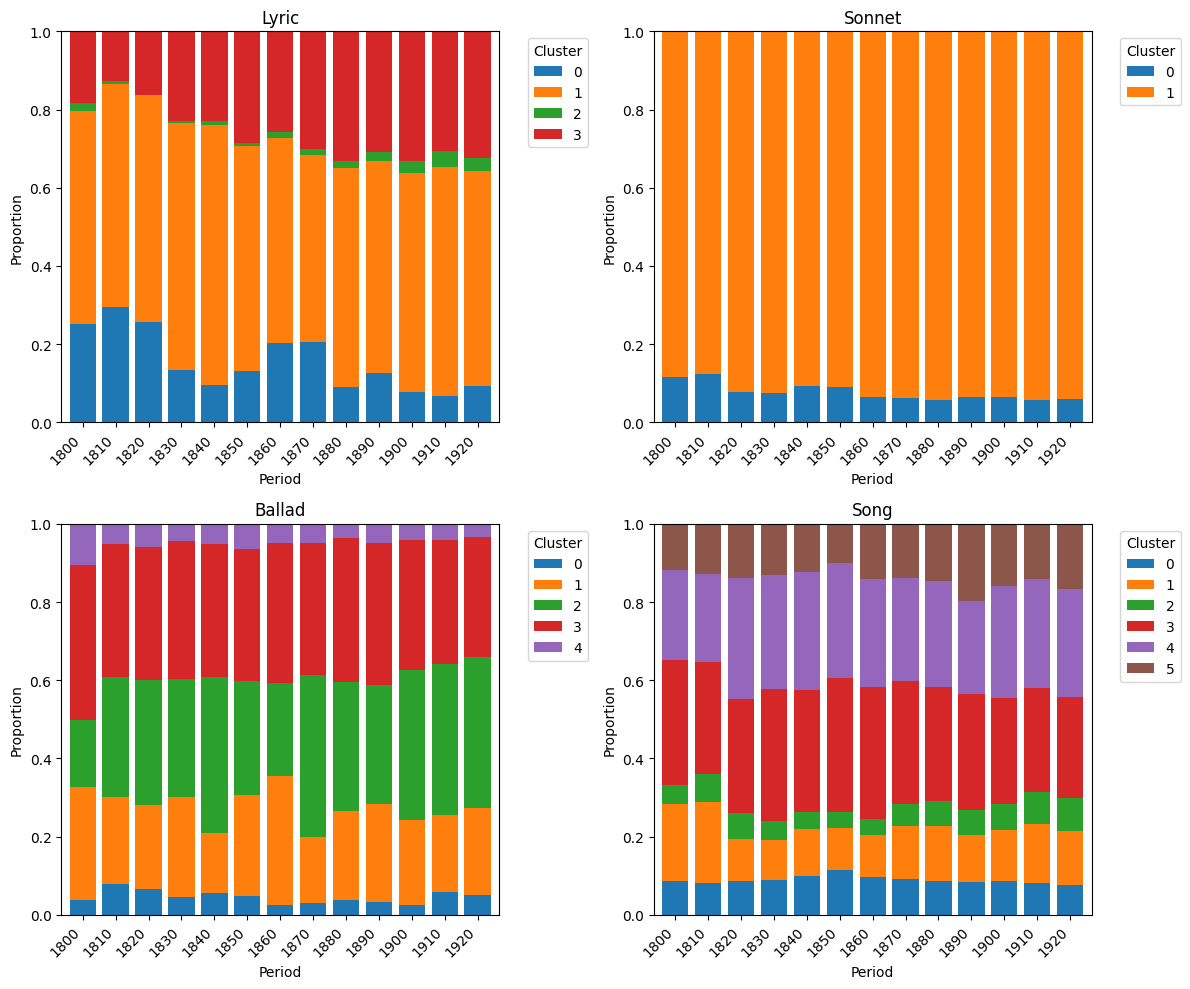

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_form_cluster_counts_by_decade(df, form, bin_size=10):
    """
    Create a stacked bar chart showing cluster proportions by time period for a given poetic form.
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame with columns: 'poetic_form', 'pub_year', 'cluster'
    form : str
        The poetic form to plot (e.g., 'Lyric', 'Sonnet')
    bin_size : int
        Years per bin (10 for decades, 25 for quarter-centuries)
    """
    # Filter for the specific form
    df_form = df[df['poetic_form'] == form].copy()
    
    # Convert pub_year to numeric and drop NaN values
    df_form['pub_year'] = pd.to_numeric(df_form['pub_year'], errors='coerce')
    df_form = df_form.dropna(subset=['pub_year'])
    
    # Skip if no data
    if len(df_form) == 0:
        return None
    
    # Filter for years >= 1800
    df_form = df_form[df_form['pub_year'] >= 1800]
    
    # Create time period column
    df_form['period'] = (df_form['pub_year'] // bin_size) * bin_size
    
    # Group by period and cluster
    count_data = df_form.groupby(['period', 'cluster']).size().reset_index(name='count')
    
    # Pivot for easier plotting
    pivot_data = count_data.pivot(index='period', columns='cluster', values='count').fillna(0)
    
    # Skip if no data after pivot
    if pivot_data.empty:
        return None
    
    # Normalize to get proportions
    pivot_proportions = pivot_data.div(pivot_data.sum(axis=1), axis=0)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create stacked bar chart
    pivot_proportions.plot(kind='bar', stacked=True, ax=ax, width=0.8)
    
    # Minimal formatting
    ax.set_xlabel('Period')
    ax.set_ylabel('Proportion')
    ax.set_title(f'{form}')
    ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_ylim(0, 1)
    
    # Format x-axis labels
    ax.set_xticklabels([int(x) for x in pivot_proportions.index], rotation=45, ha='right')
    
    plt.tight_layout()
    return fig

# To create charts for multiple forms in a grid:
def plot_forms_grid(df, forms, ncols=2, bin_size=10):
    """
    Create a grid of stacked bar charts for multiple poetic forms.
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame with columns: 'poetic_form', 'pub_year', 'cluster'
    forms : list
        List of poetic forms to plot
    ncols : int
        Number of columns in the grid
    bin_size : int
        Years per bin (10 for decades, 25 for quarter-centuries)
    """
    nrows = (len(forms) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))
    if nrows == 1 and ncols == 1:
        axes = [axes]
    elif nrows == 1 or ncols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    for idx, form in enumerate(forms):
        ax = axes[idx]
        
        # Filter and process data
        df_form = df[df['poetic_form'] == form].copy()
        df_form['pub_year'] = pd.to_numeric(df_form['pub_year'], errors='coerce')
        df_form = df_form.dropna(subset=['pub_year'])
        
        # Filter for years >= 1800
        df_form = df_form[df_form['pub_year'] >= 1800]
        
        # Skip if no data
        if len(df_form) == 0:
            ax.text(0.5, 0.5, f'No data for {form}', ha='center', va='center')
            ax.set_title(f'{form}')
            continue
        
        df_form['period'] = (df_form['pub_year'] // bin_size) * bin_size
        
        count_data = df_form.groupby(['period', 'cluster']).size().reset_index(name='count')
        pivot_data = count_data.pivot(index='period', columns='cluster', values='count').fillna(0)
        
        # Skip if no data after pivot
        if pivot_data.empty:
            ax.text(0.5, 0.5, f'No data for {form}', ha='center', va='center')
            ax.set_title(f'{form}')
            continue
            
        pivot_proportions = pivot_data.div(pivot_data.sum(axis=1), axis=0)
        
        # Plot
        pivot_proportions.plot(kind='bar', stacked=True, ax=ax, width=0.8, legend=True)
        ax.set_xlabel('Period')
        ax.set_ylabel('Proportion')
        ax.set_title(f'{form}')
        ax.set_ylim(0, 1)
        ax.set_xticklabels([int(x) for x in pivot_proportions.index], rotation=45, ha='right')
        ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    
    plt.tight_layout()
    return fig

# Example with decades starting from 1800:
plot_forms_grid(df_with_clusters, ['Lyric', 'Sonnet', 'Ballad', 'Song'], ncols=2, bin_size=10)
plt.show()

In [23]:
chart_ballad_counts = plot_form_cluster_counts_over_time(df_with_clusters, 'Ballad')
chart_ballad_counts

/var/folders/0h/_q25zy451ylc2nnqm1jkshl80000gn/T/ipykernel_68708/2984141914.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_form['pub_year'] = pd.to_numeric(df_form['pub_year'], errors='coerce')


alt.Chart(...)

In [24]:
chart_soonnet_counts = plot_form_cluster_counts_over_time(df_with_clusters, 'Sonnet')
chart_soonnet_counts

/var/folders/0h/_q25zy451ylc2nnqm1jkshl80000gn/T/ipykernel_68708/2984141914.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_form['pub_year'] = pd.to_numeric(df_form['pub_year'], errors='coerce')


alt.Chart(...)

In [25]:
chart_song_counts = plot_form_cluster_counts_over_time(df_with_clusters, 'Song')
chart_song_counts

/var/folders/0h/_q25zy451ylc2nnqm1jkshl80000gn/T/ipykernel_68708/2984141914.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_form['pub_year'] = pd.to_numeric(df_form['pub_year'], errors='coerce')


alt.Chart(...)

In [42]:
df_with_clusters.groupby(['poetic_form', 'cluster']).size().reset_index(name='counts')

,poetic_form,cluster,counts
0,Ballad,0,914
1,Ballad,1,25006
2,Lyric,0,24073
3,Lyric,1,453
4,Song,0,81831
5,Song,1,5920
6,Sonnet,0,870
7,Sonnet,1,16044


In [52]:


df_with_clusters[(df_with_clusters['poetic_form'] == 'Lyric') & (df_with_clusters['author'] == 'Schelling, Felix Emmanuel, 1858-1945') & (df_with_clusters['pub_year'] == 1913) & df_with_clusters['page_text'].str.contains('The lyric deals ')]

,page_id,work_id,poetic_form,spelling,char_start,char_end,context,embedding,page_text,author,pub_year,cluster,period_broad,period_40yr,period_10yr
42729,nyp.33433074840038.00000020,nyp.33433074840038,Lyric,lyric,11,17,THE ENGLISH LYRIC\naction and interaction. The...,"[5.091660499572754, -24.96881675720215, -14.12...",THE ENGLISH LYRIC\naction and interaction. The...,"Schelling, Felix Emmanuel, 1858-1945",1913.0,0,Modernist / Early 20th,1890–1929,1910–1919
42730,nyp.33433074840038.00000020,nyp.33433074840038,Lyric,lyric,45,51,THE ENGLISH LYRIC\naction and interaction. The...,"[-0.5756950378417969, -42.82600402832031, -8.9...",THE ENGLISH LYRIC\naction and interaction. The...,"Schelling, Felix Emmanuel, 1858-1945",1913.0,0,Modernist / Early 20th,1890–1929,1910–1919
42731,nyp.33433074840038.00000020,nyp.33433074840038,Lyric,lyric,529,535,s to that degree dramatic. In words\nderived f...,"[-9.868366241455078, -12.868042945861816, -4.6...",THE ENGLISH LYRIC\naction and interaction. The...,"Schelling, Felix Emmanuel, 1858-1945",1913.0,0,Modernist / Early 20th,1890–1929,1910–1919
42732,nyp.33433074840038.00000020,nyp.33433074840038,Lyric,lyric,689,695,and the intensity of the finest lyrical poetry...,"[-3.0344510078430176, -35.96349334716797, 2.79...",THE ENGLISH LYRIC\naction and interaction. The...,"Schelling, Felix Emmanuel, 1858-1945",1913.0,0,Modernist / Early 20th,1890–1929,1910–1919


In [54]:
df_with_clusters[df_with_clusters['page_text'].str.contains('but a lyric may be exquisite ')]

,page_id,work_id,poetic_form,spelling,char_start,char_end,context,embedding,page_text,author,pub_year,cluster,period_broad,period_40yr,period_10yr
41180,njp.32101072898651.00000133,njp.32101072898651,Lyric,lyric,259,265,gn. There never was a time\nwhen little poems ...,"[11.127254486083984, -53.30088806152344, -3.54...","SPECIAL QUALITY OF THE SONG.\nsong-making, the...","Stedman, Edmund Clarence, 1833-1908",1894.0,0,Modernist / Early 20th,1890–1929,1890–1899
41181,njp.32101072898651.00000133,njp.32101072898651,Lyric,lyric,1491,1497,"der review.\nHis stanzaic poems have, in fact,...","[1.3765058517456055, -39.76003646850586, 1.529...","SPECIAL QUALITY OF THE SONG.\nsong-making, the...","Stedman, Edmund Clarence, 1833-1908",1894.0,0,Modernist / Early 20th,1890–1929,1890–1899
41182,njp.32101072898651.00000133,njp.32101072898651,Lyric,lyric,1657,1663,"s\nconjunction. The poet Stoddard, in a prefac...","[-14.997724533081055, -48.343868255615234, -1....","SPECIAL QUALITY OF THE SONG.\nsong-making, the...","Stedman, Edmund Clarence, 1833-1908",1894.0,0,Modernist / Early 20th,1890–1929,1890–1899
46819,uc1.$b316548.00000129,uc1.$b316548,Lyric,lyric,272,278,gn. There never was a time\nwhen little poems ...,"[16.104747772216797, -51.41267395019531, -5.38...","SPECIAL QUALITY OF THE SONG.\nIOI\nthe ear,\ns...","Stedman, Edmund Clarence, 1833-1908",1903.0,0,Modernist / Early 20th,1890–1929,1900–1909
46820,uc1.$b316548.00000129,uc1.$b316548,Lyric,lyric,1497,1503,"der review.\nHis stanzaic poems have, in fact,...","[3.169912815093994, -38.92571258544922, -0.052...","SPECIAL QUALITY OF THE SONG.\nIOI\nthe ear,\ns...","Stedman, Edmund Clarence, 1833-1908",1903.0,0,Modernist / Early 20th,1890–1929,1900–1909
46821,uc1.$b316548.00000129,uc1.$b316548,Lyric,lyric,1663,1669,"s\nconjunction. The poet Stoddard, in a prefac...","[-9.76362419128418, -46.479400634765625, -2.99...","SPECIAL QUALITY OF THE SONG.\nIOI\nthe ear,\ns...","Stedman, Edmund Clarence, 1833-1908",1903.0,0,Modernist / Early 20th,1890–1929,1900–1909
47664,uc1.b3337717.00000133,uc1.b3337717,Lyric,lyric,283,289,gn. There never was\na time\nwhen little poems...,"[12.877345085144043, -52.49134063720703, -3.91...","SPECIAL QUALITY OF THE SONG.\n101\nthe ear,\n-...","Stedman, Edmund Clarence, 1833-1908",1875.0,0,Victorian,None,None
47665,uc1.b3337717.00000133,uc1.b3337717,Lyric,lyric,1494,1500,"der review.\nHis stanzaic poems have, in fact,...","[-0.19034290313720703, -38.1484375, -2.4556975...","SPECIAL QUALITY OF THE SONG.\n101\nthe ear,\n-...","Stedman, Edmund Clarence, 1833-1908",1875.0,0,Victorian,None,None
47666,uc1.b3337717.00000133,uc1.b3337717,Lyric,lyric,1660,1666,"s\nconjunction. The poet Stoddard, in a prefac...","[-10.400940895080566, -46.51218032836914, -6.6...","SPECIAL QUALITY OF THE SONG.\n101\nthe ear,\n-...","Stedman, Edmund Clarence, 1833-1908",1875.0,0,Victorian,None,None
48322,uc1.b3861089.00000133,uc1.b3861089,Lyric,lyric,272,278,ent reign. There never was\nwhen little poems ...,"[14.319623947143555, -51.69567108154297, -6.05...",SPECIAL QUALITY OF THE SONG.\nIOI\na time\nthe...,"Stedman, Edmund Clarence, 1833-1908",1915.0,0,Modernist / Early 20th,1890–1929,1910–1919


In [61]:
cosine_similarity(
    np.array(df_with_clusters.iloc[46819]['embedding']).reshape(1, -1),
    np.array(df_with_clusters.iloc[42730]['embedding']).reshape(1, -1)
)

array([[0.95536034]])

In [64]:
df_with_clusters[(df_with_clusters['poetic_form'] == 'Lyric') & (df_with_clusters['cluster'] == 0)]

,page_id,work_id,poetic_form,spelling,char_start,char_end,context,embedding,page_text,author,pub_year,cluster,period_broad,period_40yr,period_10yr
25920,A42746-p7.41,A42746-p7,Lyric,lyric,6,12,"\nCreek Lyric Poet Ba•…bylides his Master, or ...","[4.618879318237305, -13.77349853515625, 8.7484...","\nCreek Lyric Poet Ba•…bylides his Master, or ...","Gildon, Charles, 1665-1724",1694.0,0,Restoration & 18th C,None,None
25921,A54754.107,A54754,Lyric,lyric,683,689,"Poets; the other Five being\nHomerus, Eupolis,...","[-15.394283294677734, 8.828709602355957, 3.369...","\naffirm, was born in the Seventy\nthird, and ...","Phillips, Edward, 1630-1696?",1675.0,0,Restoration & 18th C,None,None
25922,A54754.11,A54754,Lyric,lyric,420,427,ar as I have observed the Italian\nStanza in H...,"[0.47612711787223816, 1.4957860708236694, -20....",\nhave been thought conducing to the perfectio...,"Phillips, Edward, 1630-1696?",1675.0,0,Restoration & 18th C,None,None
25923,A54754.119,A54754,Lyric,lyric,54,60,\nof the same name remembred by\nLaertius.\nHe...,"[1.78371000289917, -0.26410913467407227, -6.71...",\nof the same name remembred by\nLaertius.\nHe...,"Phillips, Edward, 1630-1696?",1675.0,0,Restoration & 18th C,None,None
25924,A54754.13,A54754,Lyric,lyric,934,941,e considerable is conduct and design\nin whate...,"[-11.962862014770508, 3.344609022140503, -22.8...",\nsince there are other things of much\ngreate...,"Phillips, Edward, 1630-1696?",1675.0,0,Restoration & 18th C,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50441,yale.39002005422614.00000159,yale.39002005422614,Lyric,lyric,30,36,Poetry and Painting. 139\n' Our lyric and comi...,"[-18.225379943847656, -11.452816009521484, -7....",Poetry and Painting. 139\n' Our lyric and comi...,"Dubos, abbé (Jean-Baptiste), 1670-1742",1748.0,0,Restoration & 18th C,None,None
50442,yale.39002005422614.00000161,yale.39002005422614,Lyric,lyric,800,806,"ears, appear to us as Gothic poems\ncompeted f...","[-11.854047775268555, -5.128017902374268, -15....",Poetry and Painting. 141\nfuppofes to be an En...,"Dubos, abbé (Jean-Baptiste), 1670-1742",1748.0,0,Restoration & 18th C,None,None
50443,yale.39002005422614.00000408,yale.39002005422614,Lyric,lyric,882,888,"confifts\nin images ; fince, it rather enervat...","[-7.584339618682861, -7.537529945373535, 2.520...",388 Critical Reflections on\nLe fils tout dego...,"Dubos, abbé (Jean-Baptiste), 1670-1742",1748.0,0,Restoration & 18th C,None,None
50444,yale.39002005422614.00000409,yale.39002005422614,Lyric,lyric,263,269,"\na few fentiments, they could not furnifh roo...","[8.086844444274902, -4.497020721435547, -9.370...",vv Poe try and Painting. 389\nof verfes compof...,"Dubos, abbé (Jean-Baptiste), 1670-1742",1748.0,0,Restoration & 18th C,None,None


In [67]:
df_with_clusters[(df_with_clusters['poetic_form'] == 'Lyric') & (df_with_clusters['cluster'] == 1)]['page_text'].to_clipboard()

Python(38622) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [43]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

def kmeans_average_ari_by_form(
    df,
    form_col,
    forms,
    embedding_col,
    n_clusters=2,
    n_runs=10,
    random_state=1
):

    rng = np.random.default_rng(random_state)
    results = {}

    for form in forms:
        df_form = df[df[form_col] == form]

        X = np.vstack(df_form[embedding_col].values)
        X = StandardScaler().fit_transform(X)

        labels_list = []
        for _ in range(n_runs):
            random_state=rng.integers(1e9)
            km = KMeans(
                n_clusters=n_clusters,
                n_init=5,
                random_state=random_state
            )
            labels = km.fit_predict(X)
            labels_list.append(labels)

        ari_scores = []
        for i in range(n_runs):
            for j in range(i + 1, n_runs):
                ari_scores.append(adjusted_rand_score(labels_list[i], labels_list[j]))

        results[form] = np.mean(ari_scores)

    return results


In [46]:
forms_to_check = ["Ballad", "Sonnet", "Lyric", "Song"]

mean_ari_results = kmeans_average_ari_by_form(
    df=df_filtered,
    form_col="poetic_form",
    forms=forms_to_check,
    embedding_col="embedding",
    n_clusters=2,
    n_runs=10
)

for form, mean_ari in mean_ari_results.items():
    print(f"{form}: mean ARI = {mean_ari:.3f}")

Ballad: mean ARI = 1.000
Sonnet: mean ARI = 1.000
Lyric: mean ARI = 0.523
Song: mean ARI = 1.000


In [75]:
forms_to_check = ["Pantoum"]

mean_ari_results = kmeans_average_ari_by_form(
    df=df_filtered,
    form_col="form",
    forms=forms_to_check,
    embedding_col="embedding",
    n_clusters=8,
    n_runs=10
)

for form, mean_ari in mean_ari_results.items():
    print(f"{form}: mean ARI = {mean_ari:.3f}")

Pantoum: mean ARI = 0.712


In [18]:
df_with_clusters.to_csv('../Output Data/embeddings_clusters.csv')

In [ ]:
df_other_forms = pd.read_csv('other_forms.csv')
cluster_means = (
    df_with_clusters
    .groupby(["form", "cluster"])["embedding"]
    .apply(lambda x: np.mean(np.vstack(x), axis=0))
    .reset_index()
)
other_embeddings = np.vstack(df_other_forms["embedding"].values)
TOP_K = 5
rows = []

for _, row in cluster_means.iterrows():
    cluster_emb = np.array(row["embedding"]).reshape(1, -1)

    distances = pairwise_distances(cluster_emb, other_embeddings)[0]
    top_idx = np.argsort(distances)[:TOP_K]

    for rank, idx in enumerate(top_idx, start=1):
        rows.append({
            "form": row["form"],
            "cluster": row["cluster"],
            "rank": rank,
            "closest_poetic_form": df_other_forms.iloc[idx]["poetic_form"],
            "distance": distances[idx],
        })



In [19]:
from sklearn.decomposition import PCA
import numpy as np

# 1. Get valid indices
valid_indices = df_with_clusters.index

# 2. Stack embeddings into a 2D array
vectors = [np.asarray(df_with_clusters.at[i, "embedding"], dtype=float) for i in valid_indices]
vector_matrix = np.stack(vectors)

# 3. Fit PCA
pca = PCA(n_components=2, random_state=1)
coords_2d = pca.fit_transform(vector_matrix)

# 4. Assign back into dataframe
df_with_clusters.loc[valid_indices, "x"] = coords_2d[:, 0]
df_with_clusters.loc[valid_indices, "y"] = coords_2d[:, 1]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ---- styling ----
sns.set_theme(
    style="white",
    context="paper",
    font_scale=1.2
)

plt.rcParams.update({
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "axes.spines.top": False,
    "axes.spines.right": False
})

# ---- output directory ----
out_dir = "form_cluster_plots"
os.makedirs(out_dir, exist_ok=True)

# ---- loop over forms ----
for form in sorted(df_with_clusters["form"].unique()):
    df_form = df_with_clusters[df_with_clusters["form"] == form]

    plt.figure(figsize=(6, 5))

    for cluster in sorted(df_form["cluster"].unique()):
        if cluster == -1:
            continue  # skip noise if present

        subset = df_form[df_form["cluster"] == cluster]

        plt.scatter(
            subset["x"],
            subset["y"],
            s=18,
            alpha=0.75,
            label=f"Cluster {cluster}"
        )

    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title(form)
    plt.legend(
        frameon=False,
        markerscale=1.2,
        handletextpad=0.4
    )

    plt.tight_layout()
    plt.savefig(f"{out_dir}/{form}_pca_clusters.png")
    plt.close()


In [ ]:
def assign_broad_period(year):
    if 1532 <= year <= 1659:
        return "Early Modern"
    elif 1660 <= year <= 1784:
        return "Restoration & 18th C"
    elif 1785 <= year <= 1829:
        return "Romantic"
    elif 1830 <= year <= 1889:
        return "Victorian"
    elif 1890 <= year <= 1929:
        return "Modernist / Early 20th"
    else:
        return "Other / Out of Range"


# -----------------------------------------------
# 2. Focus periods (your 40-year windows)
# -----------------------------------------------
def assign_40yr_period(year):
    if 1790 <= year <= 1829:
        return "1790–1829"
    elif 1890 <= year <= 1929:
        return "1890–1929"
    else:
        return None

# -----------------------------------------------
# 3. 10-year tranches inside each 40-year period
# -----------------------------------------------
def assign_10yr_period(year):
    # Romantic focus window
    if 1790 <= year <= 1829:
        if 1790 <= year <= 1799: return "1790–1799"
        if 1800 <= year <= 1809: return "1800–1809"
        if 1810 <= year <= 1819: return "1810–1819"
        if 1820 <= year <= 1829: return "1820–1829"

    # Modernist focus window
    if 1890 <= year <= 1929:
        if 1890 <= year <= 1899: return "1890–1899"
        if 1900 <= year <= 1909: return "1900–1909"
        if 1910 <= year <= 1919: return "1910–1919"
        if 1920 <= year <= 1929: return "1920–1929"

    return None  # not in a 10-year tranche


# -----------------------------------------------
# Apply the mappings to your embeddings dataframe
# -----------------------------------------------
df_with_clusters["period_broad"] = df_with_clusters["pub_year"].apply(assign_broad_period)
df_with_clusters["period_40yr"]   = df_with_clusters["pub_year"].apply(assign_40yr_period)
df_with_clusters["period_10yr"]   = df_with_clusters["pub_year"].apply(assign_10yr_period)


In [22]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances

# periods you want
period1 = "1790–1829"
period2 = "1890–1929"

forms = ['Ballad', 'Sonnet', 'Lyric', 'Song']
results = []

for form in forms:
    # get embeddings for each period
    emb1 = np.vstack(df_embeddings[(df_embeddings["poetic_form"] == form) &
                                     (df_embeddings["period_40yr"] == period1)]["embedding"].values)
    emb2 = np.vstack(df_embeddings[(df_embeddings["poetic_form"] == form) &
                                     (df_embeddings["period_40yr"] == period2)]["embedding"].values)
    # skip if either period is empty
    if len(emb1) == 0 or len(emb2) == 0:
        continue
    # compute cosine APD
    apd = pairwise_distances(emb1, emb2, metric="cosine").mean()
    results.append({"form": form, "apd": apd, "n_romantic": len(emb1), "n_modernist": len(emb2)})

# convert to DataFrame
apd_df = pd.DataFrame(results)
apd_df.sort_values("apd", ascending=False)


,form,apd,n_romantic,n_modernist
3,Song,0.172843,8298,47837
1,Sonnet,0.131012,1118,11700
0,Ballad,0.121402,3038,12840
2,Lyric,0.118127,2134,18473


In [ ]:


def compute_normalized_apd(df, form_col="poetic_form", period_col="period_40yr",
                           emb_col="embedding", period1="1790–1829", period2="1890–1929",
                           metric="cosine", random_state=1):
    """
    Computes:
      - within-period APD for each form
      - between-period APD for each form
      - normalized shift = between / mean(within1, within2)
    """
    rng = np.random.default_rng(random_state)
    forms = ['Ballad', 'Sonnet', 'Lyric', 'Song']
    results = []

    for form in forms:
        # get embeddings for each period
        emb1_list = df[(df[form_col] == form) & (df[period_col] == period1)][emb_col].values
        emb2_list = df[(df[form_col] == form) & (df[period_col] == period2)][emb_col].values

        emb1 = np.vstack(emb1_list)
        emb2 = np.vstack(emb2_list)


        n1, n2 = len(emb1), len(emb2)

        # within-period APD
        D1 = pairwise_distances(emb1, emb1, metric=metric)
        D2 = pairwise_distances(emb2, emb2, metric=metric)
        within1 = D1[np.triu_indices(n1, k=1)].mean()
        within2 = D2[np.triu_indices(n2, k=1)].mean()

        # between-period APD
        between = pairwise_distances(emb1, emb2, metric=metric).mean()

        # normalized shift
        norm_shift = between / ((within1 + within2)/2)

        results.append({
            "form": form,
            "n_romantic": n1,
            "n_modernist": n2,
            "within_romantic": within1,
            "within_modernist": within2,
            "between_periods": between,
            "normalized_shift": norm_shift
        })

    return pd.DataFrame(results)


In [29]:
# help me compute entropy difference between romantic and modernist time periods for each poetic form's usage distributions

from scipy.stats import entropy
def compute_entropy_difference(df, form_col="poetic_form", period_col="period_40yr",
                               cluster_col="cluster", period1="1790–1829", period2="1890–1929"):
    forms = ['Ballad', 'Sonnet', 'Lyric', 'Song']
    results = []

    for form in forms:
        df_form = df[df[form_col] == form]

        # distribution for period 1
        df_p1 = df_form[df_form[period_col] == period1]
        cluster_counts_p1 = df_p1[cluster_col].value_counts(normalize=True).sort_index()
        entropy_p1 = entropy(cluster_counts_p1)

        # distribution for period 2
        df_p2 = df_form[df_form[period_col] == period2]
        cluster_counts_p2 = df_p2[cluster_col].value_counts(normalize=True).sort_index()
        entropy_p2 = entropy(cluster_counts_p2)

        entropy_diff = entropy_p2 - entropy_p1

        results.append({
            "form": form,
            "n_romantic": len(df_p1),
            "n_modernist": len(df_p2),
            "entropy_romantic": entropy_p1,
            "entropy_modernist": entropy_p2,
            "entropy_difference": entropy_diff
        })

    return pd.DataFrame(results)
entropy_df = compute_entropy_difference(df_with_clusters)
entropy_df

,form,n_romantic,n_modernist,entropy_romantic,entropy_modernist,entropy_difference
0,Ballad,2711,12456,1.439977,1.330753,-0.109224
1,Sonnet,1109,10997,0.313234,0.229258,-0.083975
2,Lyric,1976,16009,1.065427,1.013304,-0.052122
3,Song,7473,47264,1.701514,1.674776,-0.026738


In [31]:
#lets do jensen shannon divergence instead of entropy difference
from scipy.spatial.distance import jensenshannon
def compute_jsd_between_periods(df, form_col="poetic_form", period_col="period_40yr",
                               cluster_col="cluster", period1="1790–1829", period2="1890–1929"):
    forms = ['Ballad', 'Sonnet', 'Lyric', 'Song']
    results = []

    for form in forms:
        df_form = df[df[form_col] == form]

        # distribution for period 1
        df_p1 = df_form[df_form[period_col] == period1]
        cluster_counts_p1 = df_p1[cluster_col].value_counts(normalize=True).sort_index()

        # distribution for period 2
        df_p2 = df_form[df_form[period_col] == period2]
        cluster_counts_p2 = df_p2[cluster_col].value_counts(normalize=True).sort_index()

        # align distributions
        all_clusters = sorted(set(cluster_counts_p1.index).union(set(cluster_counts_p2.index)))
        p1_dist = np.array([cluster_counts_p1.get(c, 0) for c in all_clusters])
        p2_dist = np.array([cluster_counts_p2.get(c, 0) for c in all_clusters])

        # compute JSD
        jsd = jensenshannon(p1_dist, p2_dist)

        results.append({
            "form": form,
            "n_romantic": len(df_p1),
            "n_modernist": len(df_p2),
            "jsd_between_periods": jsd
        })

    return pd.DataFrame(results)
jsd_df = compute_jsd_between_periods(df_with_clusters)
jsd_df

,form,n_romantic,n_modernist,jsd_between_periods
0,Ballad,2711,12456,0.077534
1,Sonnet,1109,10997,0.044850
2,Lyric,1976,16009,0.224548
3,Song,7473,47264,0.099770


In [16]:
compute_normalized_apd(df_with_clusters)

NameError: name 'df_with_clusters' is not defined

In [ ]:
# Euclidean distance version

from sklearn.metrics import pairwise_distances
import numpy as np
import pandas as pd

def compute_normalized_apd(
    df,
    form_col="poetic_form",
    period_col="period_40yr",
    emb_col="embedding",
    period1="1790–1829",
    period2="1890–1929",
    random_state=1
):
    """
    Computes:
      - within-period APD for each form (Euclidean)
      - between-period APD for each form (Euclidean)
      - normalized shift = between / mean(within1, within2)
    """

    forms = ["Ballad", "Sonnet", "Lyric", "Song"]
    results = []

    for form in forms:
        emb1 = np.vstack(
            df[(df[form_col] == form) & (df[period_col] == period1)][emb_col].values
        )
        emb2 = np.vstack(
            df[(df[form_col] == form) & (df[period_col] == period2)][emb_col].values
        )

        n1, n2 = len(emb1), len(emb2)

        # within-period APD (Euclidean)
        D1 = pairwise_distances(emb1, emb1, metric="euclidean")
        D2 = pairwise_distances(emb2, emb2, metric="euclidean")

        within1 = D1[np.triu_indices(n1, k=1)].mean()
        within2 = D2[np.triu_indices(n2, k=1)].mean()

        # between-period APD (Euclidean)
        between = pairwise_distances(emb1, emb2, metric="euclidean").mean()

        # normalized shift
        norm_shift = between / ((within1 + within2) / 2)

        results.append({
            "form": form,
            "n_romantic": n1,
            "n_modernist": n2,
            "within_romantic": within1,
            "within_modernist": within2,
            "between_periods": between,
            "normalized_shift": norm_shift
        })

    return pd.DataFrame(results)


In [28]:
compute_normalized_apd(df_with_clusters)

,form,n_romantic,n_modernist,within_romantic,within_modernist,between_periods,normalized_shift
0,Ballad,2711,12456,4407.033644,3223.534703,3838.574799,1.006105
1,Sonnet,1109,10997,6853.806333,4773.971068,5863.203300,1.008482
2,Lyric,1976,16009,1206.886227,2747.752334,2017.431467,1.020286
3,Song,7473,47264,9106.178293,8814.531938,8967.693121,1.000819
